##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Rasch Model [(Rasch, 1960)](https://en.wikipedia.org/wiki/Rasch_model) with TFP

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/deep_exponential_family_with_tfp.ipynb"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/deep_exponential_family_with_tfp.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>

Original content [this Repository](https://github.com/blei-lab/edward/blob/master/examples/rasch_model.py), created by [the Blei Lab](http://www.cs.columbia.edu/~blei/)

Ported to [Tensorflow Probability](https://www.tensorflow.org/probability/) by Matthew McAteer ([`@MatthewMcAteer0`](https://twitter.com/MatthewMcAteer0)), with help from Bryan Seybold, Mike Shwe ([`@mikeshwe`](https://twitter.com/mikeshwe)), Josh Dillon, and the rest of the TFP team at  Google ([`tfprobability@tensorflow.org`](mailto:tfprobability@tensorflow.org)).

---

- Dependencies & Prerequisites
- Introduction
  - Data
  - Model
  - Inference
  - Criticism
- References

## Dependencies & Prerequisites

<div class="alert alert-success">
    Tensorflow Probability is part of the colab default runtime, <b>so you don't need to install Tensorflow or Tensorflow Probability if you're running this in the colab</b>. 
    <br>
    If you're running this notebook in Jupyter on your own machine (and you have already installed Tensorflow), you can use the following
    <br>
      <ul>
    <li> For the most recent nightly installation: <code>pip3 install -q tfp-nightly</code></li>
    <li> For the most recent stable TFP release: <code>pip3 install -q --upgrade tensorflow-probability</code></li>
    <li> For the most recent stable GPU-connected version of TFP: <code>pip3 install -q --upgrade tensorflow-probability-gpu</code></li>
    <li> For the most recent nightly GPU-connected version of TFP: <code>pip3 install -q tfp-nightly-gpu</code></li>
    </ul>
Again, if you are running this in a Colab, Tensorflow and TFP are already installed
</div>

In [0]:
#@title Imports and Global Variables  { display-mode: "form" }
!pip3 install -q observations
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import string
from datetime import datetime
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
  try:
    tf.enable_eager_execution()
  except:
    pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
  """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
  Args:
  tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
    `namedtuple` or combinations thereof.
 
  Returns:
    ndarrays: Object with same structure as `tensors` except with `Tensor` or
      `EagerTensor`s replaced by Numpy `ndarray`s.
  """
  if tf.executing_eagerly():
    return tf.contrib.framework.nest.pack_sequence_as(
        tensors,
        [t.numpy() if tf.contrib.framework.is_tensor(t) else t
         for t in tf.contrib.framework.nest.flatten(tensors)])
  return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()

# from edward.models import Bernoulli, Normal, Empirical
from scipy.special import expit


## Introduction

The Rasch model, named after Georg Rasch, is a family of psychometric models for creating measurements from categorical data, such as answers to questions on a reading assessment or questionnaire responses, as a function of the trade-off between (a) the respondent's abilities, attitudes, or personality traits and (b) the item difficulty.[1] For example, they may be used to estimate a student's reading ability or the extremity of a person's attitude to capital punishment from responses on a questionnaire. In addition to psychometrics and educational research, the Rasch model and its extensions are used in other areas, including the health profession[2] and market research[3] because of their general applicability.[4]

For our example, we'll define a set of test subjects (`nsubj`), and items to which the subjects respond to (`nsubj`).

In [0]:
#@title Hyperparameters
#@markdown Number of subjects (default=200):
nsubj = 200  #@param {type:"number"}
#@markdown Number of items (default=25):
nitem = 25   #@param {type:"number"}
#@markdown Number of posterior samples (default=5000):
T = 5000     #@param {type:"number"}

### Data

From the `nsubj`, and items to which the subjects respond to `nsubj`, we will create our `X_data`. The `nsubj` is used to create a matrix describing the true values of the trait in question, and `nitem` is used to create a threshold response to each item. We use `tfd.Multinomial` to create a mock dataset from these matrices.

In [0]:
# Set seed. Remove this line to generate different mixtures!
tf.set_random_seed(77)

trait_true = tfd.Normal(loc=0., scale=1.).sample(sample_shape=[nsubj, 1], name="trait_true")
thresh_true = tfd.Normal(loc=0., scale=1.).sample(sample_shape=[1, nitem], name="thresh_true")
X_data = tfd.Multinomial(total_count=1., probs=tf.math.sigmoid(trait_true - thresh_true)).sample(name="X_data")

print("trait_true: \n", trait_true)
print("thresh_true: \n", thresh_true)
print("X_data: \n", X_data)

trait_true: 
 Tensor("Normal/trait_true/Reshape:0", shape=(200, 1), dtype=float32)
thresh_true: 
 Tensor("Normal_1/thresh_true/Reshape:0", shape=(1, 25), dtype=float32)
X_data: 
 Tensor("Multinomial/X_data/Reshape_3:0", shape=(200, 25), dtype=float32)


### Model

For our inference, we can safely assume that our `trait`s and `thresh`s can fit on a Normal distribution. Our data itself, having been generated by a Multinomial distribution, will be compared to a Bernoulli distribution.

In [0]:
trait = tfd.Normal(loc=0., scale=1.).sample(sample_shape=[nsubj, 1])
thresh = tfd.Normal(loc=0., scale=1.).sample(sample_shape=[1, nitem])
X = tfd.Bernoulli(logits=(trait - thresh))
print("trait: \n", trait)
print("thresh: \n", thresh)
print("X: \n", X)

trait: 
 Tensor("Normal_2/sample/Reshape:0", shape=(200, 1), dtype=float32)
thresh: 
 Tensor("Normal_3/sample/Reshape:0", shape=(1, 25), dtype=float32)
X: 
 tfp.distributions.Bernoulli("Bernoulli/", batch_shape=(200, 25), event_shape=(), dtype=int32)


### Inference (Strategy #1: HMC)

We can use a Hamiltonian Monte Carlo for our inference.

In [0]:
def alt_joint_log_prob(X_data, q_trait, q_thresh):
    """
    Joint log probability optimization function.
        
    Args:
      X_data: Observed data to compare Bernoulli dist. outputs to
      q_trait: Tensor array for traits
      q_thresh: Tensor array for thresholds
    Returns: 
      Joint log probability optimization function.
    Closure over:
      nsubj, nitem
    """
    tfd = tfp.distributions
    
    rv_trait = tfd.Normal(loc=tf.fill([nsubj, 1], 0.), scale=tf.fill([nsubj, 1], 1.))
    rv_thresh = tfd.Normal(loc=tf.fill([1, nitem], 0.), scale=tf.fill([1, nitem], 1.))
    rv_X = tfd.Bernoulli(logits=(q_trait - q_thresh))

    return (
        tf.reduce_sum(rv_trait.log_prob(q_trait))
        + tf.reduce_sum(rv_thresh.log_prob(q_thresh))
        + tf.reduce_sum(rv_X.log_prob(tf.to_float(X_data)))
    )

The HMC will converge based on the loss function that we've described.

In [0]:
number_of_steps = T
burnin = 0

# Set the chain's start state.
initial_chain_state = [
    0.2 * tf.ones([nsubj, 1], dtype=tf.float32, name="init_q_trait"),
    0.2 * tf.ones([1, nitem], dtype=tf.float32, name="init_q_thresh")
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),   # Maps R to R.
    tfp.bijectors.Identity()    # Maps R to R.
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: alt_joint_log_prob(X_data, *args)

# Initialize the step_size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.005, dtype=tf.float32),
        trainable=False,
        use_resource=True
    ) 

# Defining the HMC
hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=3,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

# Sample from the chain.
[
    q_trait,
    q_thresh
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc)

posterior_mean = tf.reduce_mean(q_trait[-100:], 0)
trait_mse = tf.reduce_mean(tf.square(trait_true - tf.reduce_mean(q_trait[-100:], 0)))

# Initialize any created variables.
# This prevents a FailedPreconditionError
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()


### Execute the TF graph to sample from the posterior

In [0]:
evaluate(init_g)
evaluate(init_l)
[
    q_trait_,
    trait_true_,
    posterior_mean_,
    trait_mse_,
    q_thresh_,
    kernel_results_
] = evaluate([
    q_trait,
    trait_true,
    posterior_mean,
    trait_mse,
    q_thresh,
    kernel_results
])

print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))

acceptance rate: 0.725


### Criticism (for Inference Strategy #1)

For our inference criticism, we can plot the 

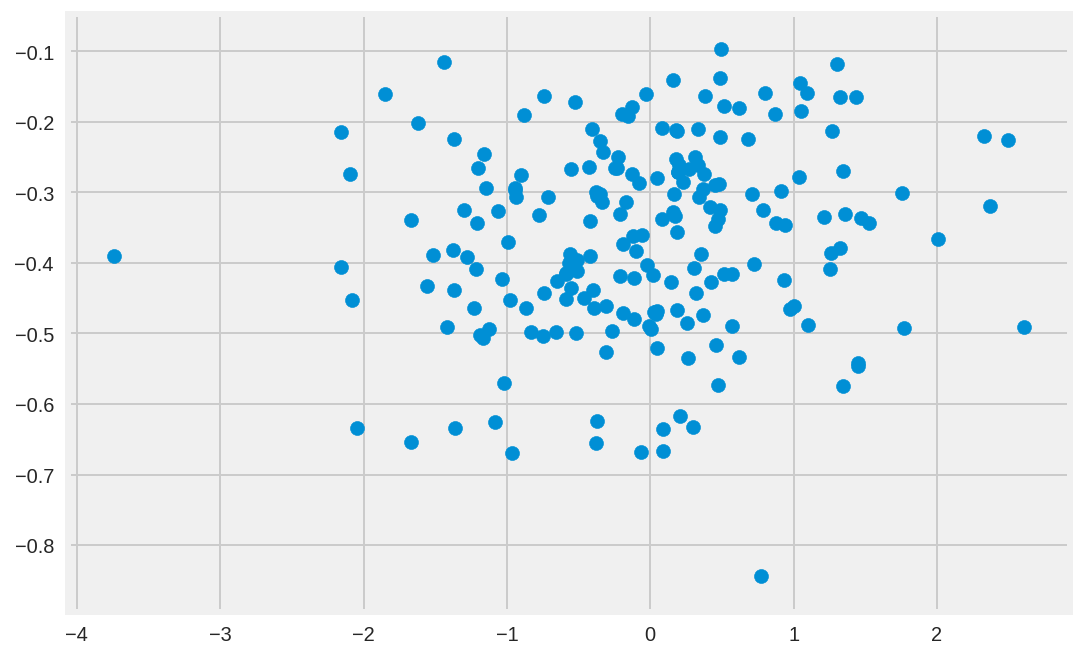

MSE between true traits and inferred posterior mean:
1.0123535


In [0]:
# Check that the inferred posterior mean captures the true traits.
plt.scatter(trait_true_, posterior_mean_)
plt.show()

print("MSE between true traits and inferred posterior mean:")
print(trait_mse_)

### Inference (Strategy #2: VI)

Alternatively, we can use variational inference for our inference

In [0]:
# First we define our Priors
trait_prior = tfd.Normal(loc=tf.fill([nsubj, 1], 0.), scale=tf.fill([nsubj, 1], 1.))
thresh_prior = tfd.Normal(loc=tf.fill([1, nitem], 0.), scale=tf.fill([1, nitem], 1.))

# Then we define our trainable distributions
q_trait = tfd.Normal(
    loc=tf.get_variable("q_trait/loc", [nsubj, 1]),
    scale=tf.nn.softplus(
        tf.get_variable("q_trait/scale", [nsubj, 1])))
q_thresh = tfd.Normal(
    loc=tf.get_variable("q_thresh/loc", [1, nitem]),
    scale=tf.nn.softplus(
        tf.get_variable("q_thresh/scale", [1, nitem])))
q_X = tfd.Bernoulli(logits=(q_trait.sample() - q_thresh.sample()))


In [0]:
# Build TF graph for fitting Normal maximum likelihood estimator.
kl = tf.reduce_mean(q_trait.kl_divergence(trait_prior))
kl += tf.reduce_mean(q_thresh.kl_divergence(thresh_prior))
loss = -tf.reduce_mean(q_X.log_prob(X_data))
elbo = kl + loss
train_op = tf.train.AdamOptimizer(learning_rate=2.**-2).minimize(elbo)
mse = tf.reduce_mean(tf.squared_difference(X_data, q_X.mean()))

init_op = tf.global_variables_initializer()

# Run graph 2500 times.
num_steps = 2500
elbo_ = evaluate(tf.zeros(num_steps)) # Style: `_` to indicate evaluate result.
mse_ = evaluate(tf.zeros(num_steps))
kl_ = evaluate(tf.zeros(num_steps))

evaluate(init_op)
for it in range(elbo_.size):
    _, elbo_[it], mse_[it], kl_[it] = evaluate([train_op, elbo, mse, kl])
    if it % 200 == 0 or it == elbo_.size - 1:
        print("iteration:{}  elbo:{:.6f}  mse:{:.6f}  KL divergence:{:.6f}".format(it, elbo_[it], mse_[it], kl_[it]))

iteration:0  elbo:1.123550  mse:0.290071  KL divergence:0.326187
iteration:200  elbo:0.843271  mse:0.225587  KL divergence:0.184257
iteration:400  elbo:0.756884  mse:0.191169  KL divergence:0.190719
iteration:600  elbo:0.818592  mse:0.216376  KL divergence:0.188345
iteration:800  elbo:0.706349  mse:0.188709  KL divergence:0.146610
iteration:1000  elbo:0.811762  mse:0.235512  KL divergence:0.142645
iteration:1200  elbo:0.864419  mse:0.218567  KL divergence:0.229878
iteration:1400  elbo:0.750865  mse:0.200397  KL divergence:0.158116
iteration:1600  elbo:0.792725  mse:0.227470  KL divergence:0.140055
iteration:1800  elbo:0.708222  mse:0.184832  KL divergence:0.159471
iteration:2000  elbo:0.704452  mse:0.196289  KL divergence:0.124700
iteration:2200  elbo:0.747243  mse:0.202052  KL divergence:0.159415
iteration:2400  elbo:0.697272  mse:0.175523  KL divergence:0.168050
iteration:2499  elbo:0.778157  mse:0.230418  KL divergence:0.108194


### Criticism (for Inference Strategy #2)

We use the same criticism strategy as before (mean squared error) for the variational inference strategy

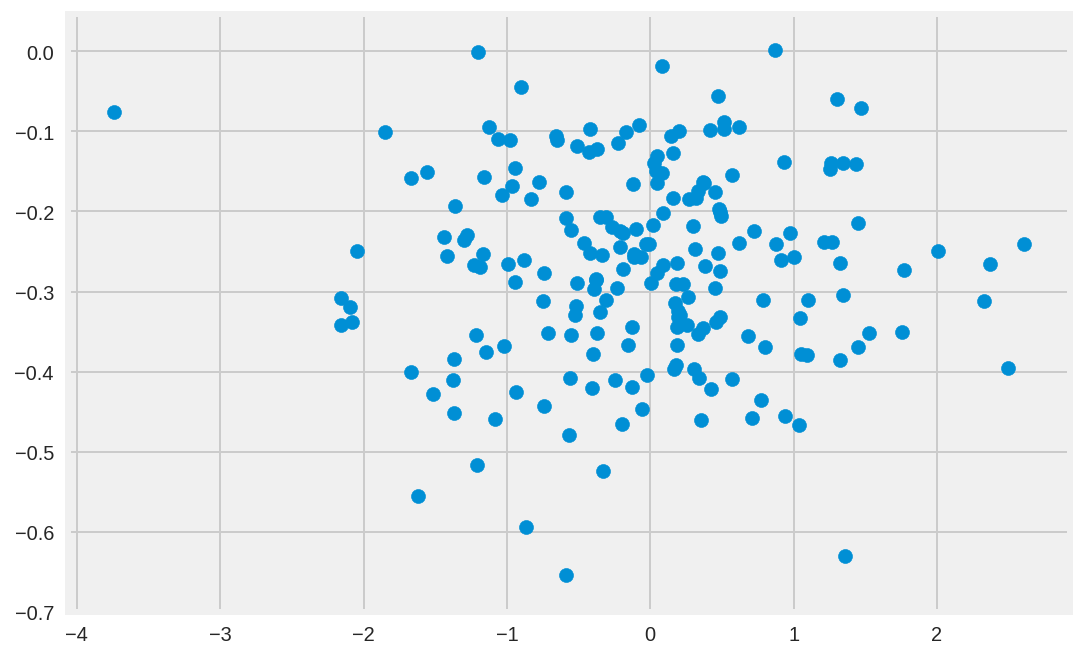

MSE between true traits and inferred posterior mean:
0.9907327


In [0]:
# Check that the inferred posterior mean captures the true traits.
plt.scatter(trait_true_, evaluate(q_trait.mean()))
plt.show()

print("MSE between true traits and inferred posterior mean:")
print(np.mean(np.square(trait_true_ - evaluate(q_trait.mean()))))

## References

[1] Rasch, G. (1960/1980). Probabilistic models for some intelligence and attainment tests.(Copenhagen, Danish Institute for Educational Research), expanded edition (1980) with foreword and afterword by B.D. Wright. Chicago: The University of Chicago Press.

[2] Bezruczko, N. (2005). Rasch measurement in health sciences. Maple Grove, MN: Jam Press.

[3] Bechtel, G. G. (1985). Generalizing the Rasch model for consumer rating scales. Marketing Science, 4(1), 62-73.

[4] Wright, B. D. (1977). Solving measurement problems with the Rasch model. Journal of Educational Measurement, 14(2), 97-116.